Loading Women's Data (Full Media Exposure)...

--- Summary Results (Rounded Integers) ---
                   Radio  Television  Newspaper  Telephone  None of the three
Rwamagana             53          16          8          3                 44
Nyagatare             52           7          8          3                 45
Gatsibo               45           5          3          1                 54
Kayonza               41           8          5          2                 56
Kirehe                48           6          4          4                 51
Ngoma                 53          11          5          1                 46
Bugesera              41          13         11          6                 54
East Province         48           9          6          3                 50
Rwanda (National)     49          11          8          4                 48
✅ Success! JSON: eastern_fp_media_all_channels.json, Plot: FP_Media_All_Channels_Grouped.png


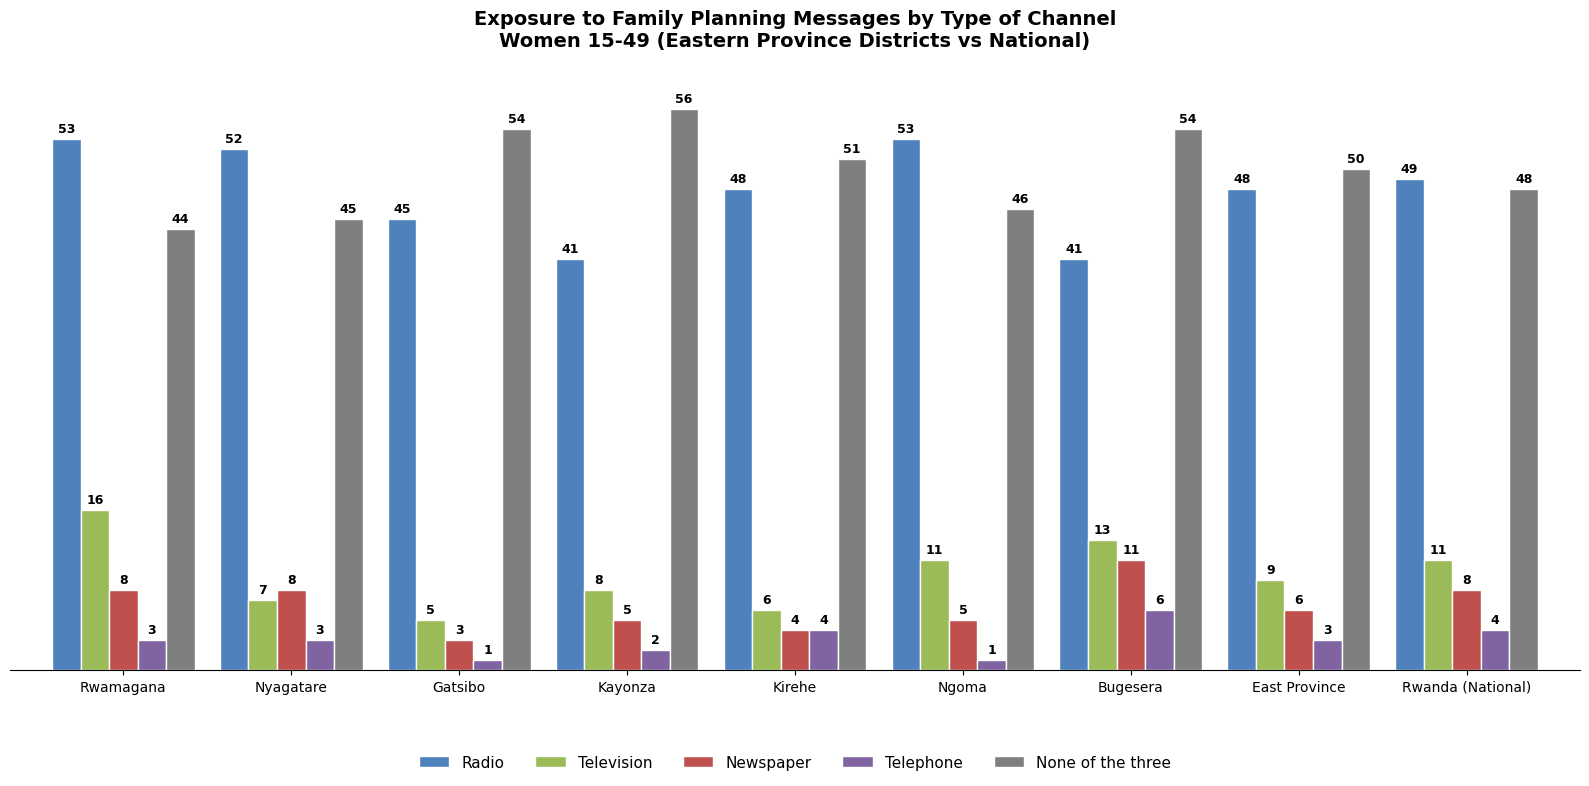

In [1]:
#!/usr/bin/env python3
# dhs_fp_media_all_channels.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

# Eastern Province Districts
DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# Variable list (Standard DHS)
# v384a=Radio, v384b=TV, v384c=Newspaper, v384d=Mobile Phone
VARS = ["v384a", "v384b", "v384c", "v384d"]

# Display Labels
LABELS = ["Radio", "Television", "Newspaper", "Telephone", "None of the three"]

# Colors for the 5 bars
COLORS = ["#4F81BD", "#9BBB59", "#C0504D", "#8064A2", "#7F7F7F"]

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    """Rounds 0.5 and up to next integer, below 0.5 down."""
    return int(math.floor(n + 0.5))

def get_full_media_stats(df):
    """Calculates weighted percentages for all media channels."""
    if df.empty or df['w'].sum() == 0:
        return pd.Series({lbl: 0 for lbl in LABELS})
    
    # 1. Individual Channels (Radio, TV, Newspaper, Telephone)
    # Code 1 = Yes
    radio_f = np.average(df['v384a'] == 1, weights=df['w']) * 100
    tv_f    = np.average(df['v384b'] == 1, weights=df['w']) * 100
    news_f  = np.average(df['v384c'] == 1, weights=df['w']) * 100
    phone_f = np.average(df['v384d'] == 1, weights=df['w']) * 100
    
    # 2. None of the three (Radio, TV, and Newspaper are all NOT 1)
    none_mask = (df['v384a'] != 1) & (df['v384b'] != 1) & (df['v384c'] != 1)
    none_f = np.average(none_mask, weights=df['w']) * 100
    
    return pd.Series({
        "Radio": standard_round(radio_f),
        "Television": standard_round(tv_f),
        "Newspaper": standard_round(news_f),
        "Telephone": standard_round(phone_f),
        "None of the three": standard_round(none_f)
    })

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data (Full Media Exposure)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- FILTERS ---
    # 1. Women Age 15-49
    df = df[(df['v012'] >= 15) & (df['v012'] <= 49)].copy()
    
    # 2. Weights & Numeric conversion
    df['w'] = pd.to_numeric(df['v005']) / 1000000.0
    for var in VARS:
        df[var] = pd.to_numeric(df[var], errors='coerce').fillna(0)

    # --- AGGREGATION ---
    results = {}
    dist_col = 'sdistrict' if 'sdistrict' in df.columns else 'sdstr'
    
    # A. Districts (Eastern Province = Region 5)
    df_east = df[df['v024'] == 5].copy()
    for d_code, d_name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == d_code]
        results[d_name] = get_full_media_stats(subset)

    # B. Province Total
    results["East Province"] = get_full_media_stats(df_east)

    # C. National Total
    results["Rwanda (National)"] = get_full_media_stats(df)

    # Create Final DataFrame
    final_df = pd.DataFrame(results).T
    final_df = final_df[LABELS] # Maintain specific column order
    
    print("\n--- Summary Results (Rounded Integers) ---")
    print(final_df)

    # --- JSON OUTPUT ---
    json_name = "eastern_fp_media_all_channels.json"
    with open(json_name, "w") as f:
        json.dump(final_df.to_dict(orient='index'), f, indent=4)

    # --- PLOTTING ---
    ax = final_df.plot(kind="bar", figsize=(16, 8), color=COLORS, width=0.85, edgecolor="white")

    plt.title("Exposure to Family Planning Messages by Type of Channel\nWomen 15-49 (Eastern Province Districts vs National)", 
              fontsize=14, fontweight="bold", pad=25)
    
    plt.xticks(rotation=0, fontsize=10)
    plt.xlabel("")
    plt.grid(axis="y", ls="--", alpha=0.3)
    
    # Visual cleanup
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: 
        ax.spines[s].set_visible(False)
    
    plt.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=5, fontsize=11)

    # Add numeric labels
    for c in ax.containers:
        ax.bar_label(c, fmt='%d', padding=3, fontsize=9, fontweight="bold")

    plt.tight_layout()
    plt.savefig("FP_Media_All_Channels_Grouped.png", dpi=300)
    print(f"✅ Success! JSON: {json_name}, Plot: FP_Media_All_Channels_Grouped.png")